## Introduction

This in-class example demonstrates how to handle time trend, seasonality, and autoregressive processes.

What you need to know:
- Statsmodels and pandas modules in python
- Theoretical concepts on time series regression model

The list of [references](#References) for detailed concepts and techniques used in this exerise.
***

## Content
- [Time trend and seasonality](#Time-Trend-and-Seasonality)
- [Autoregressive process of order 1](#Autoregressive-Process-of-Order-1)
- [Complete model with other exogenous regressors](#Complete-Model-with-other-Exogenous-Regressors)
- [References](#References)


***
## Data Description

The data set is contained in a comma-separated value (csv) file named ```CDN_hprice.csv``` with column headers. 

The data is a set of quarterly observations on a housing price index and other relevant variables in Canada for 1976 through 2019.

This data set is obtained from [Federal Reserve Bank of Dallas's International House Price Database](https://www.dallasfed.org/institute/houseprice).

Description of the data is as follow:

| Variable name | Variable description |
| -- | ----------- |
| Year      | Year |
| Quarter   | Quarter |
| RHPI      | House Price Index (real) |
| RPDI      | Personal disposable income (real) |
| logRHPI   | log(RHPI)   |
| logRPDI   | log(RPDI)   |
| UE        | Unemployment rate (in percentage points) |
| CPI       | Consumer Price Index |
| TB10_rt   | 10-year treasury bond rate (nominal) |
| RTB10_rt  | 10-year Treasury Bond rate (real) |


***
## Load the required modules

In [2]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot

***
## Import the data set

#### Load the data set into Python

In [3]:
df = pd.read_csv('CDN_hprice.csv')

***
## Data preparation

#### 1.1 Sort the data in ascending order by year and quarter

In [4]:
df = df.sort_values(by=['Year', 'Quarter'])

df.head()

,Year,Quarter,RHPI,RPDI,RTB10_rt,CPI,TB10_rt,UE,logRHPI,logRPDI
0,1976,Q1,58.98,74.11,0.835,24.414,9.327,6.867,4.0772,4.3056
1,1976,Q2,59.81,75.93,2.535,24.783,9.270,7.167,4.0912,4.3298
2,1976,Q3,58.82,73.23,2.885,25.125,8.937,7.367,4.0745,4.2936
3,1976,Q4,57.63,75.18,1.919,25.652,8.610,7.733,4.0540,4.3199
4,1977,Q1,55.78,74.07,0.943,26.310,8.783,7.867,4.0214,4.3050


#### 1.2 Generate time index

Create new variable ```t``` such that $t=0$ in the first period. 

Note that we have repeated year and quarters. You can create the the required index by:
1. Sorting the observations in ascending order, as you are asked to do in (1.1)
2. Add a new column using the ```df.index``` method, where ```df``` is the name of the pandas dataframe

In [5]:
df['t'] = range(len(df))

df[['Year', 'Quarter', 't']].head()

,Year,Quarter,t
0,1976,Q1,0
1,1976,Q2,1
2,1976,Q3,2
3,1976,Q4,3
4,1977,Q1,4


#### 1.3 Generate lag variable

Here we create lag variables with a lag of **4** period. That is, in quarterly frequency, the lag variable is in the *same* quarter but *different* year.

Create a new column in the date set named ```logRHPI_4```, such that $\text{logRHPI}\_4 = \log(\textit{RHPI}_{t-4})$ 

In [7]:
df['logRHPI_4'] = df['logRHPI'].shift(4)

df[['Year', 'Quarter', 'logRHPI', 'logRHPI_4']].head(20)

,Year,Quarter,logRHPI,logRHPI_4
0,1976,Q1,4.0772,NaN
1,1976,Q2,4.0912,NaN
2,1976,Q3,4.0745,NaN
3,1976,Q4,4.0540,NaN
4,1977,Q1,4.0214,4.0772
5,1977,Q2,4.0110,4.0912
6,1977,Q3,3.9973,4.0745
7,1977,Q4,4.0273,4.0540
8,1978,Q1,4.0205,4.0214
9,1978,Q2,4.0261,4.0110


Create a new column in the date set named ```logRPDI_4```, such that $\text{logRPDI}\_4 = \log(\textit{RPDI}_{t-4})$ 

In [8]:
df['logRPDI_4'] = df['logRPDI'].shift(4)

df[['Year', 'Quarter', 'logRPDI', 'logRPDI_4']].head(20)

,Year,Quarter,logRPDI,logRPDI_4
0,1976,Q1,4.3056,NaN
1,1976,Q2,4.3298,NaN
2,1976,Q3,4.2936,NaN
3,1976,Q4,4.3199,NaN
4,1977,Q1,4.3050,4.3056
5,1977,Q2,4.3190,4.3298
6,1977,Q3,4.3010,4.2936
7,1977,Q4,4.3086,4.3199
8,1978,Q1,4.3370,4.3050
9,1978,Q2,4.3268,4.3190


#### 1.4 Generate "*first-differencing*" variables

It is also known as the year-over-year difference, because we take the difference between now and 4 quarters (a year) ago. 

E.g. we are calulating the change from 2018 Q1 to 2019 Q1. 

Create a new column named ```gRHPI```, such that $\text{gRHPI} = \Delta \log(\textit{RHPI}_t) = \log(\textit{RHPI}_t) - \log(\textit{RHPI}_{t-4})$

In [9]:
df['gRHPI'] = df['logRHPI'] - df['logRHPI_4']

df[['Year', 'Quarter', 'logRHPI', 'logRHPI_4', 'gRHPI']].head(20)

,Year,Quarter,logRHPI,logRHPI_4,gRHPI
0,1976,Q1,4.0772,NaN,NaN
1,1976,Q2,4.0912,NaN,NaN
2,1976,Q3,4.0745,NaN,NaN
3,1976,Q4,4.0540,NaN,NaN
4,1977,Q1,4.0214,4.0772,-0.0558
5,1977,Q2,4.0110,4.0912,-0.0802
6,1977,Q3,3.9973,4.0745,-0.0772
7,1977,Q4,4.0273,4.0540,-0.0267
8,1978,Q1,4.0205,4.0214,-0.0009
9,1978,Q2,4.0261,4.0110,0.0151


#### 1.5 Plot the time series for log(RHPI) and growth rate of RHPI

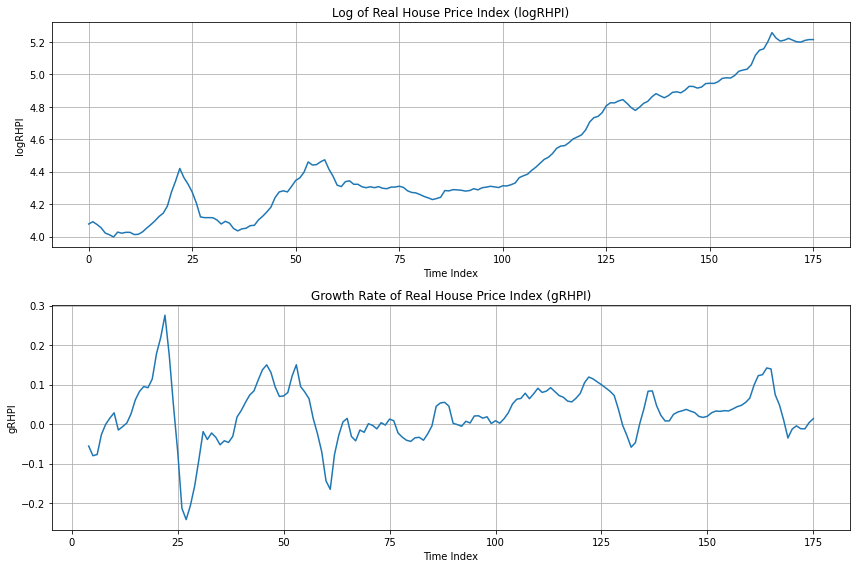

In [17]:
fig, axes = matplotlib.pyplot.subplots(2, 1, figsize=(12, 8))

axes[0].plot(df['t'], df['logRHPI'])
axes[0].set_title('Log of Real House Price Index (logRHPI)')
axes[0].set_xlabel('Time Index')
axes[0].set_ylabel('logRHPI')
axes[0].grid(True)

axes[1].plot(df['t'][4:], df['gRHPI'][4:])  
axes[1].set_title('Growth Rate of Real House Price Index (gRHPI)')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('gRHPI')
axes[1].grid(True)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

***
## Time Trend and Seasonality

Consider the following model for house price growth:
$$\log(\textit{RHPI}_t) = \beta_0 + \beta_1 t + \delta_1 Q2 + \delta_2 Q3 + \delta_3 Q4 + u_t$$

- $t = 0, 1, 2, \ldots$ is the time index you created in (1.2)
- Q2, Q3, Q4 are dummy variables that equals to 1 in the second, third, and fourth quarter, respectively. Otherwise, they are equal to 0. 

#### 2.1 Estimate the model

In [11]:
df['Q2'] = (df['Quarter'] == 'Q2').astype(int)
df['Q3'] = (df['Quarter'] == 'Q3').astype(int)
df['Q4'] = (df['Quarter'] == 'Q4').astype(int)

model1 = smf.ols(formula='logRHPI ~ t + Q2 + Q3 + Q4', data=df)
results1 = model1.fit()

#### 2.2 Get the estimation results

In [12]:
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                logRHPI   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     245.2
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           1.10e-69
Time:                        18:25:09   Log-Likelihood:                 96.886
No. Observations:                 176   AIC:                            -183.8
Df Residuals:                     171   BIC:                            -167.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9058      0.028    139.683      0.0

#### 2.3 What is the benchmark (base period) in this model?

The benchmark (base period) in this model is the first quarter (Q1) of each year. This is because we included dummy variables for Q2, Q3, and Q4, but not for Q1. Therefore, when all quarter dummies are zero, we are in Q1, which serves as the reference category.

#### 2.4 At 5% significance level, is there a statistically significant time trend?

At the 5% significance level, there is a statistically significant time trend in house prices. The time variable 't' has a coefficient of 0.0066 with a p-value of 0.000, which is well below the 0.05 threshold. This positive coefficient indicates that house prices have been consistently increasing over time at a rate of approximately 0.66% per quarter.

#### 2.5 At 5% significance level, would you conclude that house price growth exhibits seasonality at quarterly frequency?

Based on the regression results, I would conclude that house price growth does not exhibit seasonality at quarterly frequency at the 5% significance level. The p-values for all quarterly dummy variables (Q2, Q3, and Q4) are 0.721, 0.790, and 0.971 respectively, all well above the 0.05 threshold. These high p-values indicate that the seasonal effects are not statistically significant, meaning there is insufficient evidence to suggest that house prices systematically vary by quarter throughout the year.

***
## Autoregressive Process of Order 1

Consider a house price model with AR(1) specification:
$$\log(\textit{RHPI}_t) = \beta_0 + \beta_1 t + \beta_2 \log(\textit{RHPI}_{t-4}) + \delta_1 Q2 + \delta_2 Q3 + \delta_3 Q4 + u_t$$

#### 3.1 Estimate the model

In [13]:
df_ar1 = df.dropna(subset=['logRHPI_4'])
model2 = smf.ols(formula='logRHPI ~ t + logRHPI_4 + Q2 + Q3 + Q4', data=df_ar1)
results2 = model2.fit()

#### 3.2 Get the estimation results

In [14]:
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                logRHPI   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     885.5
Date:                Thu, 10 Apr 2025   Prob (F-statistic):          1.13e-117
Time:                        18:26:30   Log-Likelihood:                 216.85
No. Observations:                 172   AIC:                            -421.7
Df Residuals:                     166   BIC:                            -402.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5081      0.150      3.395      0.0

#### 3.3 At 5% significance level, what would you conclude about $\beta_2$?

At the 5% significance level, I would conclude that $\beta_2$ (the coefficient of logRHPI_4) is statistically significant. The regression results show that $\beta_2$ has a value of 0.8701 with a very small p-value of 0.000, which is well below the 0.05 threshold. This provides strong evidence to reject the null hypothesis that $\beta_2$ equals zero. The high t-statistic of 22.705 further confirms this significance. This finding indicates that house prices exhibit strong autoregressive behavior, where prices from one year ago (four quarters) significantly influence current prices. The large positive coefficient (0.8701) suggests substantial persistence in housing prices, meaning that approximately 87% of the previous year's price level is reflected in the current price level, demonstrating considerable inertia in the housing market.

#### 3.4 Does the AR(1) process have weak dependence?

At the 5% significance level, the AR(1) process exhibits weak dependence. The coefficient for logRHPI_4 ($\beta_2$) is 0.8701, which is positive and statistically significant (p-value = 0.000), but importantly, its absolute value is less than 1. For an AR(1) process to have weak dependence, the absolute value of the autoregressive coefficient must be less than 1 (|$\beta_2$| < 1), which is satisfied in this case. This indicates that the process is stationary and that shocks to housing prices will eventually dissipate over time rather than having permanent effects. The closer this coefficient is to 1, the more persistent the effects of shocks, and at 0.8701, it suggests considerable persistence but ultimately a return to equilibrium.

#### 3.5 Is the time trend still significant? Why or why not?

Yes, the time trend remains statistically significant, though its magnitude has decreased from 0.0066 to 0.0011. The p-value of 0.000 is still well below the 0.05 threshold. This reduction occurs because the autoregressive term (logRHPI_4) now captures much of the persistence in house prices that was previously attributed to the time trend. The continued significance of the time variable indicates that housing prices exhibit a genuine long-term upward trend independent of their autoregressive properties.

***
## Complete Model with other Exogenous Regressors

Consider a house price model with AR(1) specification and other exogenous regressors:
$$\log(\textit{RHPI}_t) = \beta_0 + \beta_1 t + \beta_2 \log(\textit{RHPI}_{t-4}) + \beta_3 \textit{UE}_t + \beta_4 \log(\textit{RPDI}_t) + \delta_1 Q2 + \delta_2 Q3 + \delta_3 Q4 + u_t$$

#### 4.1 Estimate the model

In [15]:
model3 = smf.ols(formula='logRHPI ~ t + logRHPI_4 + UE + logRPDI + Q2 + Q3 + Q4', data=df_ar1)
results3 = model3.fit()

#### 4.2 Get the estimation results

In [16]:
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                logRHPI   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1162.
Date:                Thu, 10 Apr 2025   Prob (F-statistic):          3.45e-136
Time:                        18:27:00   Log-Likelihood:                 268.72
No. Observations:                 172   AIC:                            -521.4
Df Residuals:                     164   BIC:                            -496.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7270      0.632     -4.316      0.0

#### 4.3 How would you interpret $\beta_3$? (Be careful on how unemployment rate is reported in the data set)

Based on the regression results, $\beta_3$(the coefficient for unemployment rate UE) is -0.0180 and statistically significant. Since unemployment is measured in percentage points in the dataset, this coefficient indicates that a one percentage point increase in unemployment rate is associated with approximately a 1.8% decrease in the Real House Price Index, holding all other variables constant. This negative relationship aligns with economic theory, as rising unemployment typically reduces housing demand and prices.

#### 4.4 At 5% significance level, what would you conclude about $\beta_3$?

At the 5% significance level, I would conclude that $\beta_3$ is statistically significant. The regression results show a p-value of 0.000 for the unemployment rate coefficient, which is well below the 0.05 threshold. This provides strong evidence to reject the null hypothesis that $\beta_3$ equals zero. The negative coefficient (-0.0180) confirms that unemployment rate has a significant negative effect on house prices, with each percentage point increase in unemployment associated with approximately a 1.8% decrease in the Real House Price Index.

#### 4.5 Explain why the AR(1) dependence ($\beta_2$) is weakened, when compare with your results in Question 3.

The AR(1) dependence ($\beta_2$) has weakened from 0.8701 in model 2 to 0.6701 in model 3 because we've introduced important economic variables (unemployment rate and personal disposable income) that explain significant variation in house prices. In the previous model, the autoregressive term was capturing not only pure price persistence but also the implicit effects of these omitted economic variables. By explicitly including UE and logRPDI in the model, they now account for some of the variation previously attributed to the autoregressive term. This demonstrates that part of what appeared to be simple price momentum was actually reflecting the underlying economic conditions that drive housing markets.

***
## References
- Jeffrey M. Wooldridge (2019). "Introductory Econometrics: A Modern Approach, 7e" Chapter 11.
    
- The pandas development team (2020). "[pandas-dev/pandas: Pandas](https://pandas.pydata.org/)." Zenodo.
    
- Seabold, Skipper, and Josef Perktold (2010). "[statsmodels: Econometric and statistical modeling with python](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)." Proceedings of the 9th Python in Science Conference.